In [1]:
import os 
import autograd.numpy as np
from autograd import grad, hessian
from autograd.scipy.special import gammaln
from autograd.scipy.misc import logsumexp

import numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "crimson",
               "greyish",
               "dark grey"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")


In [2]:
# Sample the model
mu = 0.0
sigmasq = 9.0
N = 3
def logistic(x): return 1./(1+np.exp(-x))
def loglogistic(x): return -np.log(1+np.exp(-x))

# x = npr.normal(mu, np.sqrt(sigmasq))
x = 0
y = npr.rand(N) < logistic(x)
print("x =", x)
print("y =", y)


x = 0
y = [False False False]


In [3]:
# Plot the prior, likelihood, and posterior
xx = np.linspace(-8,2,1000)
dx = xx[1]-xx[0]
def prior(vx):
    return -0.5 * np.log(2*np.pi*sigmasq) - 0.5 * (vx-mu)**2 / sigmasq

def lkhd(vx):
    return np.sum(loglogistic(vx) * y[:,None] + loglogistic(-vx) * (1-y[:,None]) , axis=0)

def post(vx):
    return prior(vx) + lkhd(vx)

def normalized_post(vx):
    p = post(vx)
    p = p - np.log(dx) - logsumexp(p)
    return p

In [4]:
# compute a Laplace approximation
mu_hat = xx[np.argmax(post(xx))]
hess = grad(grad(post))
sigmasq_hat = -1./hess(mu_hat)
laplace = lambda vx: -0.5 * np.log(2*np.pi*sigmasq_hat) - 0.5 * (vx-mu_hat)**2 / sigmasq_hat
print(sigmasq_hat)

2.86770627942


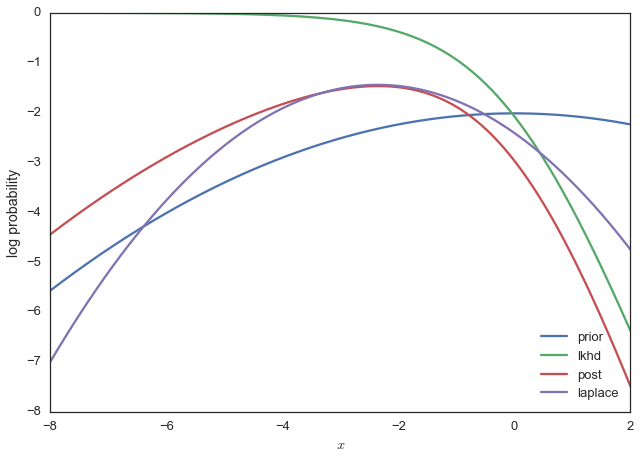

In [5]:
# Plot and show that it
plt.plot(xx, prior(xx), label="prior")
plt.plot(xx, lkhd(xx), label="lkhd")
plt.plot(xx, normalized_post(xx), label="post")
plt.plot(xx, laplace(xx), label="laplace")
plt.legend(loc="lower right")
plt.xlabel("$x$")
plt.ylabel("log probability")

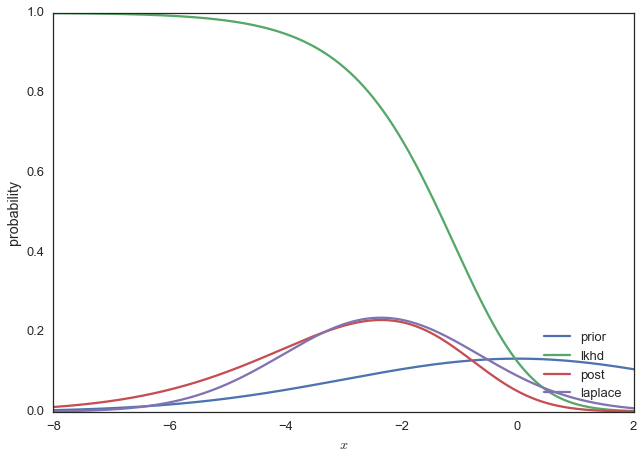

In [6]:
# Plot and show that it
plt.plot(xx, np.exp(prior(xx)), label="prior")
plt.plot(xx, np.exp(lkhd(xx)), label="lkhd")
plt.plot(xx, np.exp(normalized_post(xx)), label="post")
plt.plot(xx, np.exp(laplace(xx)), label="laplace")
plt.legend(loc="lower right")
plt.xlabel("$x$")
plt.ylabel("probability")

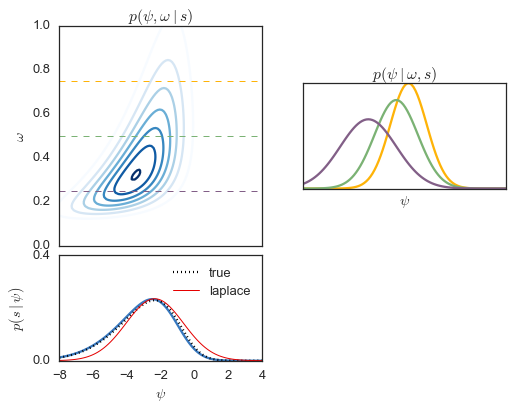

In [7]:
# Polya gamma augmentation
import pypolyagamma
npts = 100
xg, om = np.meshgrid(np.linspace(-8,4,npts),
                     np.linspace(1e-6,1.0,npts),)
oms_to_plot = [.75, 0.50, 0.25]

a = y.sum()
b = N
kappa = a - b/2.0
px = np.exp(-0.5 * (xg - mu)**2/sigmasq + kappa * xg - 0.5 * om * xg**2)
pom = pypolyagamma.pgpdf(om, N, 0.0, trunc=200)

paug = px * pom

# Plot augmented joint
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)
gs = GridSpec(6,2)

ax = fig.add_subplot(gs[:4,0])
plt.contour(xg, om, paug, cmap="Blues")
for i,o in enumerate(oms_to_plot):
    plt.plot(xg[0], o*np.ones(npts), '--', lw=1, color=colors[2+i])
    
# plt.xlabel("$x$")
plt.xticks([])
plt.ylabel("$\omega$")
plt.title("$p(\psi, \omega \mid s)$")

# Plot the marginal over x
px = paug.sum(axis=0)
px /= np.trapz(px, xg[0])
true_px = np.exp(post(xg[0]))
true_px /= np.trapz(true_px, xg[0])

ax = fig.add_subplot(gs[4:,0])
plt.plot(xg[0], px, color=colors[0])
plt.plot(xg[0], true_px, ':k', label="true")
plt.plot(xg[0], np.exp(laplace(xg[0])), color=colors[1], lw=1, label="laplace")
plt.yticks([0, 0.4])
plt.xlabel("$\psi$")
plt.ylabel("$p(s \mid \psi)$")
plt.legend(loc="upper right")

# Plot slices 
for i,o in enumerate(oms_to_plot):
    oind = np.argmin((om[:,0]-o)**2)
    px = paug[oind]
    px /= np.trapz(px, xg[0])
    ax = fig.add_subplot(gs[1:3,1])
    plt.plot(xg[0], px, color=colors[2+i])
    plt.yticks([])
    if i == 0:
        plt.title("$p(\psi \mid \omega, s)$")
    if i < len(oms_to_plot) - 1:
        plt.xticks([])
    else:
        plt.xlabel("$\psi$")


# Two dimensional case

In [8]:
# Sample the model
from pybasicbayes.util.stats import sample_invwishart
D = 10
M = 10
rho = 0.75
mu = np.zeros(D)
rho = 0.5
J = np.eye(D) + rho * np.eye(D, k=1) + rho * np.eye(D, k=-1)
# Sigma = sample_invwishart((D + 3) * np.eye(D), D+3.)
Sigma = np.linalg.inv(J)
np.set_printoptions(precision=2)
print(Sigma)
x = npr.multivariate_normal(mu, Sigma)
y = npr.binomial(M, logistic(x))


[[ 1.82 -1.64  1.45 -1.27  1.09 -0.91  0.73 -0.55  0.36 -0.18]
 [-1.64  3.27 -2.91  2.55 -2.18  1.82 -1.45  1.09 -0.73  0.36]
 [ 1.45 -2.91  4.36 -3.82  3.27 -2.73  2.18 -1.64  1.09 -0.55]
 [-1.27  2.55 -3.82  5.09 -4.36  3.64 -2.91  2.18 -1.45  0.73]
 [ 1.09 -2.18  3.27 -4.36  5.45 -4.55  3.64 -2.73  1.82 -0.91]
 [-0.91  1.82 -2.73  3.64 -4.55  5.45 -4.36  3.27 -2.18  1.09]
 [ 0.73 -1.45  2.18 -2.91  3.64 -4.36  5.09 -3.82  2.55 -1.27]
 [-0.55  1.09 -1.64  2.18 -2.73  3.27 -3.82  4.36 -2.91  1.45]
 [ 0.36 -0.73  1.09 -1.45  1.82 -2.18  2.55 -2.91  3.27 -1.64]
 [-0.18  0.36 -0.55  0.73 -0.91  1.09 -1.27  1.45 -1.64  1.82]]


In [9]:
from autograd.scipy.stats import multivariate_normal as mvn

def prior(X):
    return mvn.logpdf(X, mu, Sigma)

def lkhd(X):
    assert y.shape == (D,)
    oned = X.ndim == 1
    if oned:
        return np.sum(loglogistic(X) * y + loglogistic(-X) * (M-y))
    else:
        return np.sum(loglogistic(X) * y + loglogistic(-X) * (M-y), axis=1)
    

def post(vx):
    return prior(vx) + lkhd(vx)

def normalized_post(vx):
    p = post(vx)
    p = p - D*np.log(dx) - logsumexp(p)
    return p

In [10]:
# compute a Laplace approximation
# mu_hat = xx[np.argmax(post(xx))]
from scipy.optimize import minimize
def objective(vx):
    return -1 * post(vx)

res = minimize(objective, np.zeros(D), jac=grad(objective))
mu_hat = res.x

hess = hessian(post)
Sigma_hat = -np.linalg.inv(hess(mu_hat))

def laplace(X):
    return mvn.logpdf(X, mu_hat, Sigma_hat)

def laplace_marginal(X, inds):
    return mvn.logpdf(X[:, inds], mu_hat[np.ix_(inds)], Sigma_hat[np.ix_(inds, inds)])


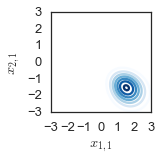

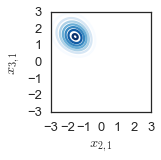

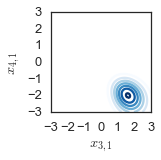

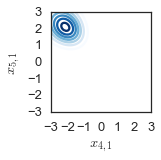

In [11]:
f = np.exp
npts = 100

for i in range(4):
    inds = (i, i+1)
    xx, yy = np.meshgrid(np.linspace(-3,3,npts),
                         np.linspace(-3,3,npts))
    dx = xx[0,1] - xx[0,0]
    dy = yy[1,0] - yy[0,0]

    xy = np.zeros((npts**2, D)) 
    xy[:,inds[0]] = xx.ravel()
    xy[:,inds[1]] = yy.ravel()

    fig = plt.figure(figsize=(2.5,2.5))
    fig.patch.set_alpha(0)
    plt.contour(xx, yy, f(normalized_post(xy)).reshape((npts, npts)), cmap="Blues")
    plt.xlabel("$x_{{{0},1}}$".format(inds[0]+1))
    plt.ylabel("$x_{{{0},1}}$".format(inds[1]+1))
    plt.tight_layout()


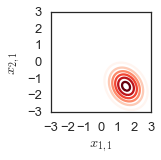

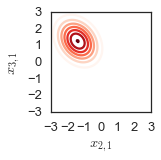

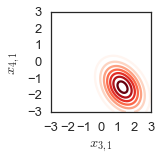

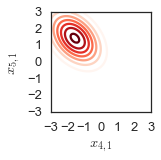

In [12]:
f = np.exp
npts = 100

for i in range(4):
    inds = (i, i+1)
    xx, yy = np.meshgrid(np.linspace(-3,3,npts),
                         np.linspace(-3,3,npts))
    dx = xx[0,1] - xx[0,0]
    dy = yy[1,0] - yy[0,0]

    xy = np.zeros((npts**2, D)) 
    xy[:,inds[0]] = xx.ravel()
    xy[:,inds[1]] = yy.ravel()

    fig = plt.figure(figsize=(2.5,2.5))
    fig.patch.set_alpha(0)
    plt.contour(xx, yy, f(laplace(xy)).reshape((npts, npts)), cmap="Reds")
    plt.xlabel("$x_{{{0},1}}$".format(inds[0]+1))
    plt.ylabel("$x_{{{0},1}}$".format(inds[1]+1))
    plt.tight_layout()
